In [1]:
from functions_for_all_nutrients import *
from vitamin_a_and_zinc_functions import *
from low_ses_functions import *

In [2]:
# Get absolute path of repo based on relative directory structure,
# so it should work for all users
import os.path
vivarium_research_lsff_path = os.path.abspath("..")
vivarium_research_lsff_path

'/ihme/homes/alibow/notebooks/vivarium_research_lsff'

In [3]:
username = !whoami
username

['alibow']

In [4]:
# Make shared directories in which to store GBD data so we don't have to keep calling `get_draws`

# Nathaniel has saved some .hdf files in this directory:
# You can change it if you save GBD data in a different directory.
read_share_dir = f'/share/scratch/users/ndbs/vivarium_lsff/gbd_data'

# GBD data will be stored here in an .hdf file if it doesn't exist in the directory above:
# You can change this directory name if you want, and you may need to create it before running code below.
#write_share_dir = f'/share/scratch/users/{username[0]}/vivarium_lsff/gbd_data'

In [5]:
index_cols=['location_id','sex_id','age_group_id']
age_group_ids = [2,3,4,5]
sex_ids = [1,2]
coverage_levels = [0.2,0.5,0.8]
years = [2021,2022,2023,2024,2025]

In [6]:
coverage_data_dir = vivarium_research_lsff_path + '/multiplication_models/low_ses_coverage.csv'
# # Old version that may not work for all users:
# coverage_data_dir = f'/ihme/homes/{username[0]}/notebooks/' \
#     'vivarium_research_lsff/data_prep/outputs/lsff_input_coverage_data.csv'

In [7]:
location_ids = [214]
location_ids

[214]

In [8]:
vitamin_a_burden_multiplier = 1.2
zinc_burden_multiplier = 1.2

In [9]:
cause_ids = [341, #measles
            302] #diarrheal diseases]

In [10]:
burden_multipliers = pd.DataFrame()
burden_multipliers['cause_id'] = cause_ids
burden_multipliers['multiplier'] = [1.48,1.45]
burden_multipliers

,cause_id,multiplier
0,341,1.48
1,302,1.45


# VITAMIN A

In [11]:
# vitamin A specific -- these should be replaced for other models
rei_id = 96
nutrient = 'vitamin a'
vehicles = ['oil','wheat flour','maize flour']
effective_fractions = [0, 0, (365 - (365 * 0.5)) / (365 - 28), 1]

In [12]:
# define no fortification relative risk distribution
# vitamin a specific -- this should be replaced for other models

from numpy import log
from scipy.stats import norm, lognorm

# median and 0.975-quantile of lognormal distribution for RR
median = 2.22
q_975 = 5.26

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

mu = log(median) # mean of normal distribution for log(RR)
sigma = (log(q_975) - mu) / q_975_stdnorm # std dev of normal distribution for log(RR)

# Frozen lognormal distribution for RR, representing uncertainty in our effect size
# (s is the shape parameter)b
rr_distribution = lognorm(s=sigma, scale=median)

In [13]:
vitamin_a_baseline_coverage, vitamin_a_counterfactual_coverage = get_baseline_and_counterfactual_coverage(coverage_data_dir,
                                             location_ids,
                                             nutrient,
                                             vehicles,
                                             years,
                                             coverage_levels, 'U5')

Excluded location IDs [] due to missing data
Excluded location IDs [] due to missing data
Excluded location IDs [] due to missing data


In [14]:
vitamin_a_baseline_effective_coverage = get_effective_vitamin_a_coverage(vitamin_a_baseline_coverage.set_index(['location_id','year','vehicle']), 
                                                               sex_ids,
                                                               age_group_ids,
                                                               effective_fractions,
                                                               years)
vitamin_a_counterfactual_effective_coverage = get_effective_vitamin_a_coverage(vitamin_a_counterfactual_coverage.set_index(['location_id','year','vehicle','coverage_level']), 
                                                               sex_ids,
                                                               age_group_ids,
                                                               effective_fractions,
                                                               years)

In [15]:
vitamin_a_rr_deficiency_nofort = generate_rr_deficiency_nofort_draws(mu, sigma, location_ids)
vitamin_a_rr_deficiency_nofort.mean(axis=1)

location_id
214    2.396239
dtype: float64

In [16]:
vitamin_a_exposure = pull_exposure(rei_id, sex_ids, age_group_ids, location_ids)
adjusted_exposure = adjust_exposure(vitamin_a_exposure, 'cat1', vitamin_a_burden_multiplier, ['location_id','age_group_id','sex_id'])

In [17]:
dalys = pull_affected_dalys([341, 302], age_group_ids, sex_ids, location_ids)

In [18]:
adjusted_dalys = adjust_dalys(dalys, burden_multipliers)

In [19]:
relative_risks = pull_relative_risks(rei_id, age_group_ids, sex_ids)

In [20]:
pafs = calculate_adjusted_paf(adjusted_exposure, relative_risks)

In [21]:
attributable_daly_rates = calculate_attributable_dalys(dalys, pafs)

In [22]:
vitamin_a_dalys = calculate_overall_attributable_daly_counts(attributable_daly_rates, age_group_ids, location_ids, sex_ids)
vitamin_a_dalys = add_in_adjusted_paf_of_one(vitamin_a_dalys, location_ids, sex_ids, age_group_ids, 389, vitamin_a_burden_multiplier)

In [23]:
vitamin_a_paf_deficiency_nofort = calculate_paf_deficiency_nofort(
                                    vitamin_a_rr_deficiency_nofort, 
                                    vitamin_a_baseline_effective_coverage)

In [24]:
vitamin_a_pif_deficiency_nofort = calculate_pif_deficiency_nofort(
                                    vitamin_a_paf_deficiency_nofort,
                                    vitamin_a_baseline_effective_coverage,
                                    vitamin_a_counterfactual_effective_coverage)

In [25]:
vitamin_a_overall_pifs, vitamin_a_daly_reduction_counts = calculate_final_pifs_and_daly_reductions(
                                                    vitamin_a_pif_deficiency_nofort,
                                                    vitamin_a_dalys,
                                                    coverage_levels, years)

In [26]:
vitamin_a_daly_reduction_rates = calculate_rates(vitamin_a_daly_reduction_counts, 
                                            location_ids, 
                                            age_group_ids, 
                                            sex_ids)

In [27]:
vitamin_a_overall_pifs['measure'] = 'pif'
vitamin_a_daly_reduction_counts['measure'] = 'counts_averted'
vitamin_a_daly_reduction_rates['measure'] = 'rates_averted'
vitamin_a_results = pd.concat([vitamin_a_overall_pifs.reset_index(),
                         vitamin_a_daly_reduction_counts.reset_index(),
                         vitamin_a_daly_reduction_rates.reset_index()],
                        ignore_index=True)

# pull in overall national results
vitamin_a_national = pd.read_pickle(vivarium_research_lsff_path + '/multiplication_models/results_raw/vitamin_a.pkl')
vitamin_a_national = vitamin_a_national.loc[vitamin_a_national.location_id.isin(vitamin_a_results.reset_index().location_id.unique())]

# location_comparisons
vitamin_a_results['subgroup'] = 'Lower Wealth Quintile'
vitamin_a_national['subgroup'] = 'Total Population'
vitamin_a_results = pd.concat([vitamin_a_results,vitamin_a_national], ignore_index=True)
vitamin_a_results.head()

draws,location_id,year,vehicle,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,...,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999,measure,subgroup
0,214,2021.0,maize flour,0.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pif,Lower Wealth Quintile
1,214,2021.0,maize flour,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pif,Lower Wealth Quintile
2,214,2021.0,maize flour,0.8,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pif,Lower Wealth Quintile
3,214,2021.0,oil,0.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pif,Lower Wealth Quintile
4,214,2021.0,oil,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pif,Lower Wealth Quintile


# ZINC

In [28]:
# ZINC
rei_id = 97
nutrient = 'zinc'
vehicles = ['wheat flour', 'maize flour']
effective_fractions = [0,0,0,1]

In [29]:
# define no fortification relative risk distribution
# vitamin a specific -- this should be replaced for other models

from numpy import log
from scipy.stats import norm, lognorm

# median and 0.975-quantile of lognormal distribution for RR
median = 0.47
q_975 = 0.69

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

mu = log(median) # mean of normal distribution for log(RR)
sigma = (log(q_975) - mu) / q_975_stdnorm # std dev of normal distribution for log(RR)

# Frozen lognormal distribution for RR, representing uncertainty in our effect size
# (s is the shape parameter)
rr_distribution = lognorm(s=sigma, scale=median)

In [30]:
zinc_baseline_coverage, zinc_counterfactual_coverage = zinc_baseline_coverage, zinc_counterfactual_coverage = get_baseline_and_counterfactual_coverage(coverage_data_dir,
                                             location_ids,
                                             'zinc',
                                             ['wheat flour','maize flour'],
                                             years,
                                             coverage_levels, 'U5')

Excluded location IDs [] due to missing data
Excluded location IDs [] due to missing data


In [31]:
zinc_rr_deficiency_nofort = (1 / generate_rr_deficiency_nofort_draws(mu, sigma, location_ids))

In [32]:
zinc_baseline_effective_coverage = apply_age_related_effective_coverage_restrictions(
                                                                zinc_baseline_coverage.set_index([c for c in zinc_baseline_coverage.columns if 'draw' not in c]),
                                                                sex_ids,
                                                                age_group_ids,
                                                                effective_fractions)
zinc_counterfactual_effective_coverage = apply_age_related_effective_coverage_restrictions(
                                                                zinc_counterfactual_coverage.set_index([c for c in zinc_counterfactual_coverage.columns if 'draw' not in c]),
                                                                sex_ids,
                                                                age_group_ids,
                                                                effective_fractions)

In [33]:
zinc_exposure = pull_exposure(97, sex_ids, age_group_ids, location_ids)

In [34]:
zinc_rrs = pull_relative_risks(97, age_group_ids, sex_ids)

In [35]:
adjusted_zinc_exposure = adjust_exposure(zinc_exposure, 'cat1', 
                                         zinc_burden_multiplier, ['location_id','age_group_id','sex_id'])

In [36]:
zinc_affected_dalys = pull_affected_dalys(302, age_group_ids, sex_ids, location_ids)

In [37]:
zinc_adjusted_dalys = adjust_dalys(zinc_affected_dalys, burden_multipliers)

In [38]:
zinc_pafs = calculate_adjusted_paf(adjusted_zinc_exposure, zinc_rrs)

In [39]:
zinc_dalys = calculate_attributable_dalys(zinc_adjusted_dalys, zinc_pafs)
pop = get_population(sex_id=sex_ids,
                              age_group_id=age_group_ids,
                              location_id=location_ids,
                              year_id=2019,
                              gbd_round_id=6,
                             decomp_step='step4')
zinc_dalys = zinc_dalys.reset_index().merge(pop, on=['location_id','age_group_id','sex_id'])
for i in list(range(0,1000)):
    zinc_dalys[f'draw_{i}'] = zinc_dalys[f'draw_{i}'] * zinc_dalys[f'population']
zinc_dalys = zinc_dalys.groupby('location_id').sum()
zinc_dalys = zinc_dalys.drop(columns=[c for c in zinc_dalys.columns if 'draw' not in c])
zinc_dalys.head()

,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,draw_106,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
location_id,,,,,,,,,,,,,,,,,,,,,
214,51300.1371,2065.556997,20559.742051,51612.461148,9640.084838,8462.588628,12737.508661,57109.155998,65017.797232,24860.551979,...,39678.070848,91256.861564,18409.050934,36466.181398,118937.619232,105547.704419,36584.847017,25675.689673,33571.078735,49939.469604


In [40]:
zinc_paf_deficiency_nofort = calculate_paf_deficiency_nofort(
                                    zinc_rr_deficiency_nofort, 
                                    zinc_baseline_effective_coverage)

In [41]:
zinc_pif_deficiency_nofort = calculate_pif_deficiency_nofort(
                                    zinc_paf_deficiency_nofort,
                                    zinc_baseline_effective_coverage,
                                    zinc_counterfactual_effective_coverage)

In [42]:
zinc_overall_pifs, zinc_daly_reduction_counts = calculate_final_pifs_and_daly_reductions(
                                                    zinc_pif_deficiency_nofort,
                                                    zinc_dalys,
                                                    coverage_levels, years)

In [43]:
zinc_daly_reduction_rates = calculate_rates(zinc_daly_reduction_counts, 
                                            location_ids, 
                                            age_group_ids, 
                                            sex_ids)

In [44]:
zinc_overall_pifs['measure'] = 'pif'
zinc_daly_reduction_counts['measure'] = 'counts_averted'
zinc_daly_reduction_rates['measure'] = 'rates_averted'
zinc_results = pd.concat([zinc_overall_pifs.reset_index(),
                         zinc_daly_reduction_counts.reset_index(),
                         zinc_daly_reduction_rates.reset_index()],
                        ignore_index=True)
zinc_national_results = pd.read_pickle(vivarium_research_lsff_path + '/multiplication_models/results_raw/zinc.pkl')
zinc_national_results = zinc_national_results.loc[zinc_national_results.location_id.isin(vitamin_a_results.reset_index().location_id.unique())]
# location_comparisons
zinc_results['subgroup'] = 'Lower Wealth Quintile'
zinc_national_results['subgroup'] = 'Total Population'
zinc_results = pd.concat([zinc_results,zinc_national_results], ignore_index=True)
zinc_results.head()

draws,location_id,year,vehicle,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,...,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999,measure,subgroup
0,214,2021.0,maize flour,0.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pif,Lower Wealth Quintile
1,214,2021.0,maize flour,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pif,Lower Wealth Quintile
2,214,2021.0,maize flour,0.8,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pif,Lower Wealth Quintile
3,214,2021.0,wheat flour,0.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pif,Lower Wealth Quintile
4,214,2021.0,wheat flour,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pif,Lower Wealth Quintile


# Folic Acid

In [45]:
from mult_model_fns import *
from folic_acid.folic_acid_mult_model_fns import *

In [46]:
sexes = [1,2]
ages = [2,3,4,5]

draws = [f'draw_{i}' for i in range(1_000)]
index_cols=['location_id','sex_id','age_group_id']

# define alternative scenario coverage levels (low, medium, high)
    # this parameter represents the proportion of additional coverage achieved in the
    # alternative scenario, defined as the difference between the proportion of the population
    # that eats the fortified vehicle and the proportion of the population that eats 
    # the industrially produced vehicle
alternative_scenario_coverage_levels = [0.2, 0.5, 0.8]
coverage_levels = alternative_scenario_coverage_levels

rei_id = [] #folic acid doesn't effect any risks; just NTDs
cause_ids = [642] # NTDs
nonfatal_causes = [642] # YLLs and YLDs
nutrient = 'folic acid'
vehicles = ['maize flour', 'wheat flour'] 
ntd_burden_multiplier = 1.9

In [47]:
# define no fortification relative risk distribution
# folic acid specific -- this should be replaced for other models

from numpy import log
from scipy.stats import norm, lognorm

# median and 0.975-quantile of lognormal distribution for RR
median = 1.71
q_975 = 2.04

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

mu = log(median) # mean of normal distribution for log(RR)
sigma = (log(q_975) - mu) / q_975_stdnorm # std dev of normal distribution for log(RR)

In [48]:
# calculate relative risk for lack of fortification
# https://vivarium-research.readthedocs.io/en/latest/concept_models/vivarium_conic_lsff/concept_model.html#effect-size-folic-acid
rr_ntds_nofort = format_rrs(lognormal_draws(mu, sigma, seed = 7), location_ids)
rr_ntds_nofort.mean(axis=1)

location_id
214    1.712028
dtype: float64

In [49]:
dalys = pull_dalys(cause_ids, cause_ids, location_ids, ages, sexes, index_cols)
dalys = dalys * ntd_burden_multiplier
dalys.head()

draw_0         draw_1  \
location_id sex_id age_group_id cause_id                                 
214         1      2            642       371654.350684  386420.944817   
                   3            642        91950.154891   98988.128002   
                   4            642       219205.901261  255927.350726   
                   5            642        69514.717045   70895.564240   
            2      2            642       306044.594554  367523.818857   

                                                draw_10       draw_100  \
location_id sex_id age_group_id cause_id                                 
214         1      2            642       408576.519470  369463.788284   
                   3            642        91700.730925   76079.180311   
                   4            642       237631.759195  176955.775749   
                   5            642        76151.755169  102729.665638   
            2      2            642       232360.213230  479655.493223   

                                               draw_101       draw_102  \
location_id sex_id age_group_id cause_id                                 
214         1      2            642       277590.780637  454249.752867   
                   3            642        87033.756918  128456.849137   
                   4            642       240942.237385  317819.023184   
                   5            642        60879.241542  101688.133258   
            2      2            642       340292.191067  306885.255405   

                                               draw_103       draw_104  \
location_id sex_id age_group_id cause_id                                 
214         1      2            642       128967.746274  192585.662321   
                   3            642        46352.170130   44311.209668   
                   4            642       110479.064599  127007.188455   
                   5            642        49831.740455   44090.634038   
            2      2            642       272122.145649  367452.873504   

                                               draw_105       draw_106  ...  \
location_id sex_id age_group_id cause_id                                ...   
214         1      2            642       207262.068624  215861.627186  ...   
                   3            642        40963.841682   50359.243330  ...   
                   4            642       111500.187686  118900.839130  ...   
                   5            642        72001.264279   41761.751040  ...   
            2      2            642       365110.970477  334222.344053  ...   

                                               draw_990       draw_991  \
location_id sex_id age_group_id cause_id                                 
214         1      2            642       973711.787553  707822.620698   
                   3            642       146064.764447   96548.988290   
                   4            642       506474.381088  402903.219760   
                   5            642       580354.683367  532207.819749   
            2      2            642       628574.962663  538605.555438   

                                               draw_992       draw_993  \
location_id sex_id age_group_id cause_id                                 
214         1      2            642       571634.862518  505884.695647   
                   3            642       159747.628844  113662.347304   
                   4            642       523373.982363  406292.210430   
                   5            642       755778.810062  434940.741712   
            2      2            642       462893.390582  618597.029790   

                                               draw_994       draw_995  \
location_id sex_id age_group_id cause_id                                 
214         1      2            642       535430.778939  762361.867689   
                   3            642       121240.001572  162170.385940   
                   4            642       325882.974519  482676.603178   
           

In [50]:
pop = get_population(gbd_round_id=6,
                    location_id=location_ids,
                    sex_id=sexes,
                    age_group_id=ages,
                    year_id=2019,
                    decomp_step='step4')

In [51]:
low_ses_results = pd.DataFrame()
for vehicle in vehicles:
    data = pull_coverage_data(coverage_data_dir, nutrient, vehicle, location_ids, 'wra')
    data = create_marginal_uncertainty(data)
    data.loc[(data.location_name=="Burkina Faso") &
         (data.value_description == "percent of population eating industrially produced vehicle"), 
         'value_mean'] = 2 * data.value_mean
    # data.loc[(data.location_name=="Burkina Faso") &
    #      (data.value_description == "percent of population eating industrially produced vehicle"), 
    #      'value_025_percentile'] = 2 * data.value_025_percentile
    data.loc[(data.location_name=="Burkina Faso") &
         (data.value_description == "percent of population eating industrially produced vehicle"), 
         'value_975_percentile'] = 2 * data.value_975_percentile
    alpha, alpha_star = generate_coverage_tables(data, alternative_scenario_coverage_levels, seed = 11)
    gets_intervn = prop_gets_intervention_effect(location_ids, year_start=2022, estimation_years = range(2022,2026))
    new_coverage = percolate_new_coverage(gets_intervn, alpha, alpha_star)
    paf_ntds_nofort = paf_o_r(rr_ntds_nofort, alpha)
    pif_ntds_nofort = pif_o_r(paf_ntds_nofort, alpha = alpha, alpha_star = new_coverage)
    dalys_averted = calc_dalys_averted(dalys, pif_ntds_nofort)
    dalys_averted_u5 = dalys_averted.reset_index().groupby(['location_id','year_id','coverage_level']).sum()[draws]
    dalys_averted_u5['vehicle'] = vehicle
    counts = dalys_averted_u5.reset_index().loc[dalys_averted_u5.reset_index().year_id==2025]
    counts['measure'] = 'counts_averted'
    counts = counts.set_index([c for c in counts.columns if 'draw' not in c])
    rates = counts.reset_index().merge(pop.groupby('location_id').sum().drop(columns='year_id'), on='location_id')
    for i in list(range(0,1000)):
        rates[f'draw_{i}'] = rates[f'draw_{i}'] / rates['population'] * 100_000
    rates['measure'] = 'rates_averted'
    rates = rates.set_index(['location_id','measure','coverage_level','year_id'])
    rates = rates.drop(columns=[c for c in rates.columns if 'draw' not in c])
    pif = (counts / dalys.groupby('location_id').sum() * 100).reset_index()
    pif['measure'] = 'pif'
    pif = pif.set_index(['location_id','measure','coverage_level','year_id'])
    vehicle_results = pd.concat([rates, pif], sort=True).reset_index()
    vehicle_results['vehicle'] = vehicle
    low_ses_results = pd.concat([vehicle_results, low_ses_results], ignore_index=True)
    
low_ses_results

/ihme/code/central_comp/miniconda_svc-ccomp/envs/v108/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,location_id,measure,coverage_level,year_id,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,...,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999,vehicle
0,214,rates_averted,0.2,2025,63.750716,48.125108,55.331100,60.637377,55.765401,82.481996,...,93.708439,97.899438,146.488991,96.170398,150.420759,112.959703,126.644411,115.349932,143.763441,wheat flour
1,214,rates_averted,0.5,2025,159.376790,120.312770,138.327751,151.593442,139.413502,206.204989,...,234.271097,244.748596,366.222477,240.425995,376.051898,282.399259,316.611028,288.374830,359.408603,wheat flour
2,214,rates_averted,0.8,2025,255.002863,192.500433,221.324401,242.549508,223.061603,329.927983,...,374.833755,391.597754,585.955963,384.681592,601.683037,451.838814,506.577645,461.399727,575.053765,wheat flour
3,214,pif,0.2,2025,1.502827,0.989587,1.369069,1.116728,1.294171,1.585389,...,0.961682,0.970887,1.619448,0.960464,1.133570,1.035544,0.961203,0.959730,1.091445,wheat flour
4,214,pif,0.5,2025,3.757068,2.473966,3.422672,2.791820,3.235428,3.963472,...,2.404204,2.427218,4.048621,2.401159,2.833925,2.588861,2.403006,2.399324,2.728612,wheat flour
5,214,pif,0.8,2025,6.011309,3.958346,5.476276,4.466911,5.176685,6.341555,...,3.846727,3.883549,6.477793,3.841854,4.534280,4.142178,3.844810,3.838919,4.365779,wheat flour
6,214,rates_averted,0.2,2025,15.486320,4.644926,22.175688,17.853787,14.457560,35.720483,...,23.765306,11.666786,65.378308,28.507334,48.132201,23.861158,33.277036,30.305819,55.839374,maize flour
7,214,rates_averted,0.5,2025,38.715801,11.612316,55.439220,44.634468,36.143900,89.301207,...,59.413264,29.166965,163.445770,71.268335,120.330502,59.652896,83.192589,75.764547,139.598435,maize flour
8,214,rates_averted,0.8,2025,61.945281,18.579706,88.702753,71.415149,57.830240,142.881931,...,95.061222,46.667144,261.513232,114.029336,192.528803,95.444634,133.108142,121.223275,223.357497,maize flour
9,214,pif,0.2,2025,0.365067,0.095513,0.548698,0.328804,0.335523,0.686584,...,0.243891,0.115702,0.722763,0.284706,0.362724,0.218744,0.252565,0.252149,0.423930,maize flour


In [52]:
# pull in overall folic_acid_national_resultsional results
folic_acid_national_results = pd.read_pickle('/ihme/homes/alibow/notebooks/vivarium_research_lsff/' + '/multiplication_models/results_raw/folic_acid.pkl')
folic_acid_national_results = folic_acid_national_results.loc[folic_acid_national_results.location_id.isin(low_ses_results.reset_index().location_id.unique())]
# location_comparisons
low_ses_results['subgroup'] = 'Lower Wealth Quintile'
low_ses_results['nutrient'] = nutrient
folic_acid_national_results['subgroup'] = 'Total Population'
folic_acid_results = pd.concat([low_ses_results.reset_index(),
                     folic_acid_national_results.loc[folic_acid_national_results.year_id==2025]], 
                               ignore_index=True).rename(columns={'year_id':'year'})
folic_acid_results.head()

/ihme/code/central_comp/miniconda_svc-ccomp/envs/v108/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,...,draw_997,draw_998,draw_999,index,location_id,measure,nutrient,subgroup,vehicle,year
0,0.2,63.750716,48.125108,55.331100,60.637377,55.765401,82.481996,31.454384,54.693036,38.594671,...,126.644411,115.349932,143.763441,0.0,214,rates_averted,folic acid,Lower Wealth Quintile,wheat flour,2025
1,0.5,159.376790,120.312770,138.327751,151.593442,139.413502,206.204989,78.635961,136.732590,96.486679,...,316.611028,288.374830,359.408603,1.0,214,rates_averted,folic acid,Lower Wealth Quintile,wheat flour,2025
2,0.8,255.002863,192.500433,221.324401,242.549508,223.061603,329.927983,125.817537,218.772145,154.378686,...,506.577645,461.399727,575.053765,2.0,214,rates_averted,folic acid,Lower Wealth Quintile,wheat flour,2025
3,0.2,1.502827,0.989587,1.369069,1.116728,1.294171,1.585389,0.982782,1.394804,1.036739,...,0.961203,0.959730,1.091445,3.0,214,pif,folic acid,Lower Wealth Quintile,wheat flour,2025
4,0.5,3.757068,2.473966,3.422672,2.791820,3.235428,3.963472,2.456955,3.487010,2.591846,...,2.403006,2.399324,2.728612,4.0,214,pif,folic acid,Lower Wealth Quintile,wheat flour,2025


# Results Viz

In [53]:
vitamin_a_results['nutrient'] = 'vitamin a'
zinc_results['nutrient'] = 'zinc'
folic_acid_results['nutrient'] = 'folic acid'

results = pd.concat([vitamin_a_results,
                    zinc_results,
                    folic_acid_results], ignore_index=True, sort=True)
results.head()

,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,...,draw_997,draw_998,draw_999,index,location_id,measure,nutrient,subgroup,vehicle,year
0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,214,pif,vitamin a,Lower Wealth Quintile,maize flour,2021.0
1,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,214,pif,vitamin a,Lower Wealth Quintile,maize flour,2021.0
2,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,214,pif,vitamin a,Lower Wealth Quintile,maize flour,2021.0
3,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,214,pif,vitamin a,Lower Wealth Quintile,oil,2021.0
4,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,214,pif,vitamin a,Lower Wealth Quintile,oil,2021.0


In [56]:
def make_ses_comparison_dot_plots(data, nutrient, vehicle, measure, coverage_levels, subtitle, wra=False):
    """This function takes a dataframe,
    nutrient (as a string),
    and measure (as a string, either: 'rates', 'counts', or 'pifs').
    """

    f, ax = plt.subplots(figsize=(7, 4), dpi=120)
    colors = ['tab:red', 'tab:orange', 'tab:green']

    location_spacer = 0.15
    coverage_spacer = 0.025
    df = (data.drop(columns='measure', errors='ignore')
          .apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).reset_index())

    for n in list(range(0, len(coverage_levels))):
        rate = (df.loc[df.year == 2025]
            .loc[df.coverage_level == coverage_levels[n]])
        for i in list(range(0, len(rate))):
            plt.plot([location_spacer * i + coverage_spacer * n, location_spacer * i + coverage_spacer * n],
                     [rate['2.5%'].values[i], rate['97.5%'].values[i]], c='black')
            plt.scatter([location_spacer * i + coverage_spacer * n], rate['2.5%'].values[i], s=50, marker='_',
                        c='black')
            plt.scatter([location_spacer * i + coverage_spacer * n], rate['97.5%'].values[i], s=50, marker='_',
                        c='black')

        x_vals = []
        for x in list(range(0, len(rate))):
            x_vals.append(location_spacer * x + coverage_spacer * n)
        plt.scatter(x_vals, rate['mean'], s=50,
                    label=f'{int(coverage_levels[n] * 100)} percent coverage', color=colors[n])

    plt.hlines(0, 0 - coverage_spacer * 2,
               location_spacer * (len(rate)) - coverage_spacer * 2,
               linestyle='dashed', color='grey', alpha=0.5)

    plt.plot()

    if wra == True:
        subpop = 'Women of Reproductive Age'
    else:
        subpop = 'children under five'

    if measure == 'rates':
        plt.title(f'DALYs averted per 100,000 person-years due to\n{nutrient} fortication in {vehicle} among {subpop}\n{subtitle}')
        plt.ylabel('DALYs Averted per 100,000')
    elif measure == 'counts':
        plt.title(f'DALYs averted due to\n{nutrient} fortication in {vehicle} among {subpop}\n{subtitle}')
        plt.ylabel('DALYs')
    elif measure == 'pifs':
        plt.title(f'Population impact fraction of {nutrient} fortication in {vehicle} \non DALYs among {subpop}\n{subtitle}')
        plt.ylabel('Population Impact Fraction (Percent)')

    plt.legend(bbox_to_anchor=[1.5, 1])

    x_ticks = []
    for x in list(range(0, len(rate))):
        x_ticks.append(location_spacer * x + coverage_spacer)
    ax.set_xticks(x_ticks)
    l = get_ids('location')
    l_names = df.loc[df.coverage_level == coverage_levels[0]].loc[df.year == 2025]
    l_names = l_names.reset_index().merge(l, on='location_id')
    l_names['label'] = l_names.location_name + ' ' + l_names.subgroup
    l_names = list(l_names.label.values)
    ax.set_xticklabels(l_names)

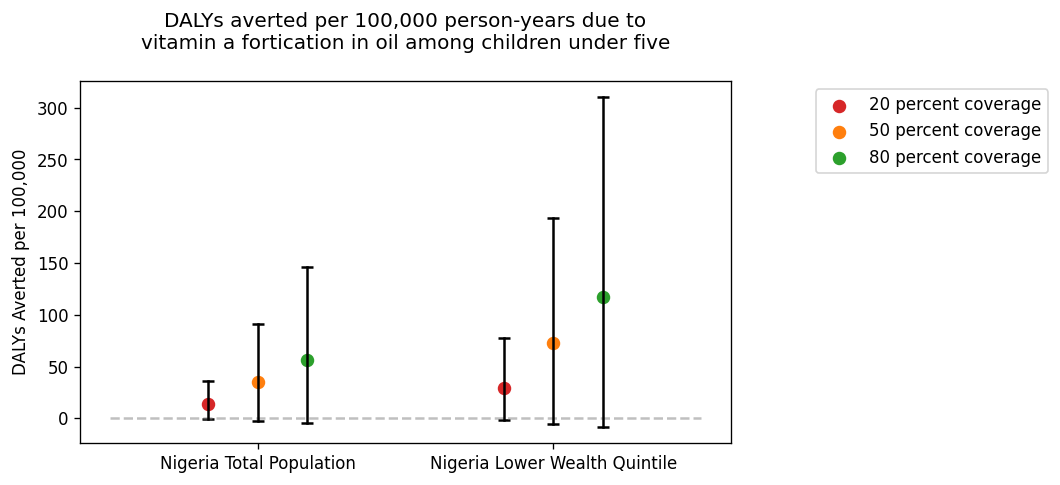

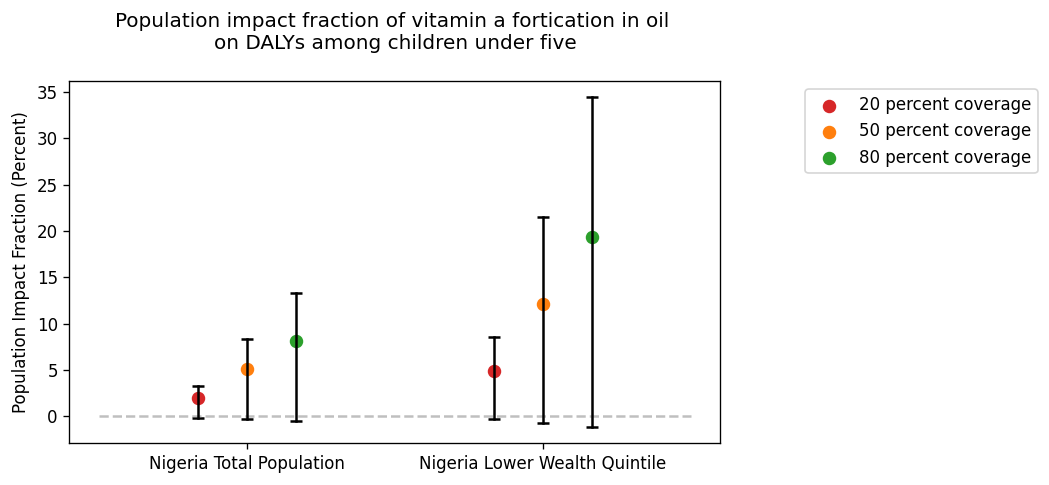

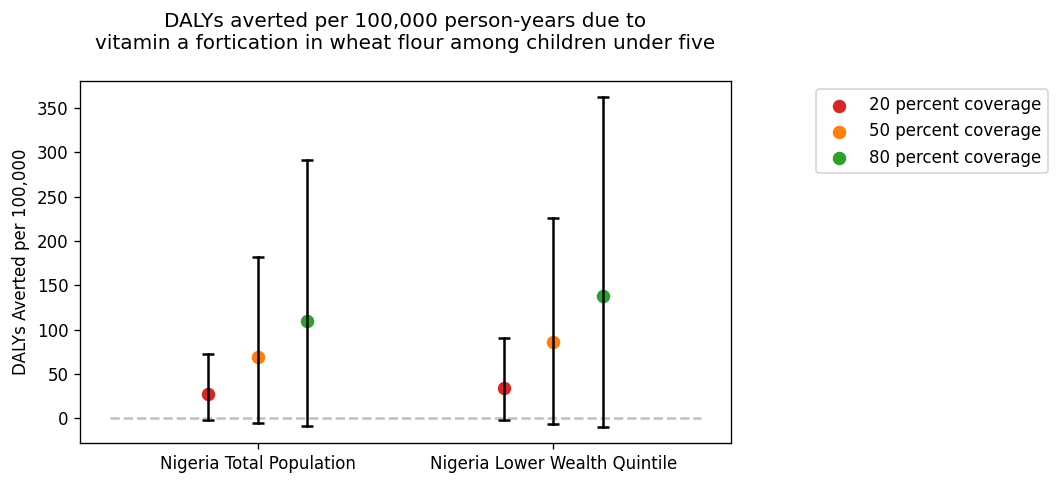

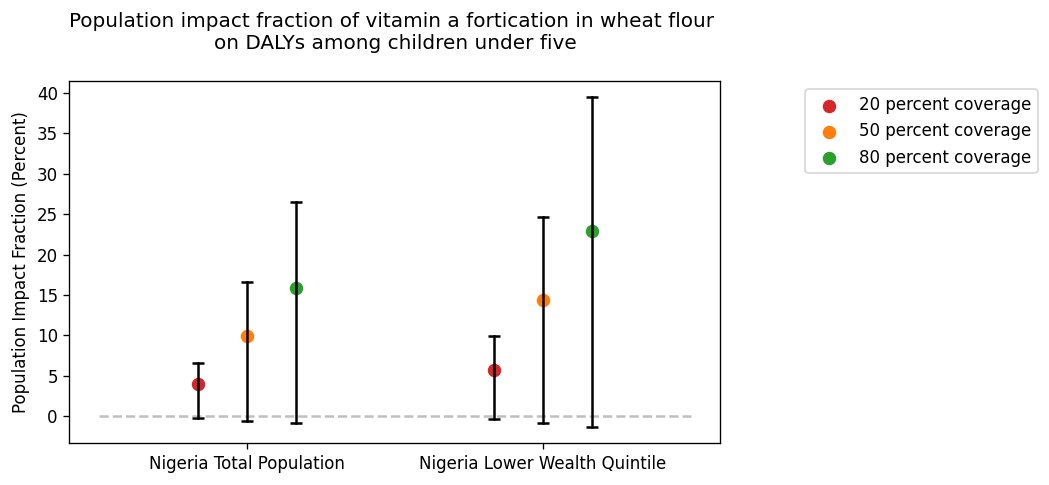

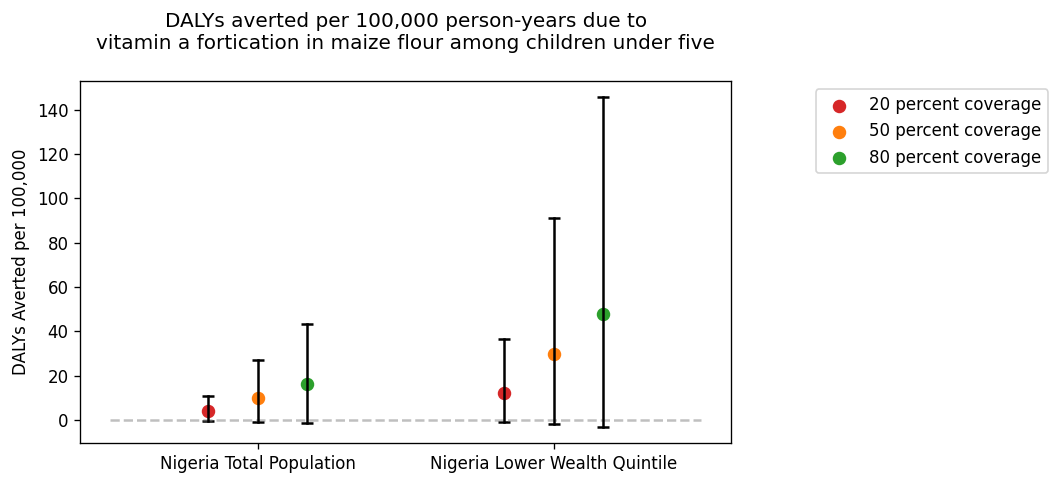

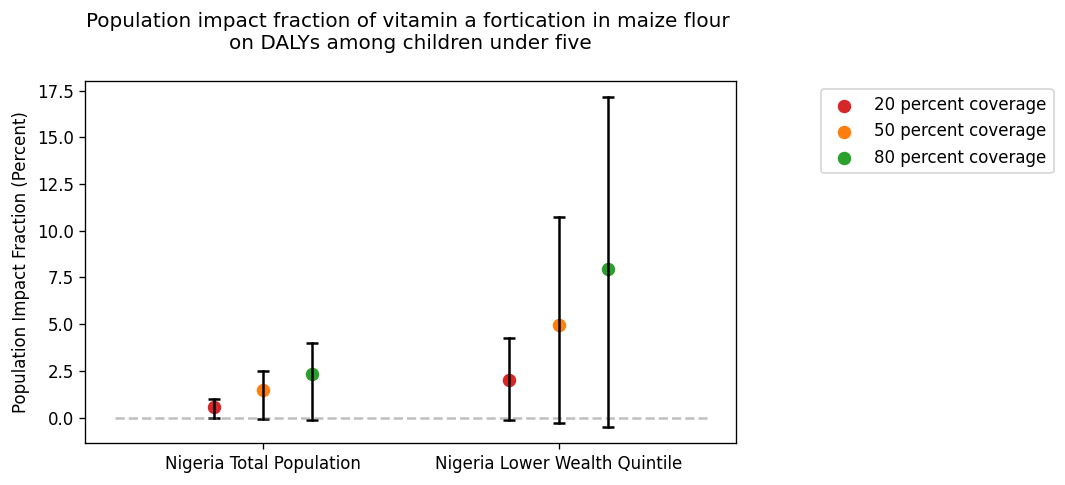

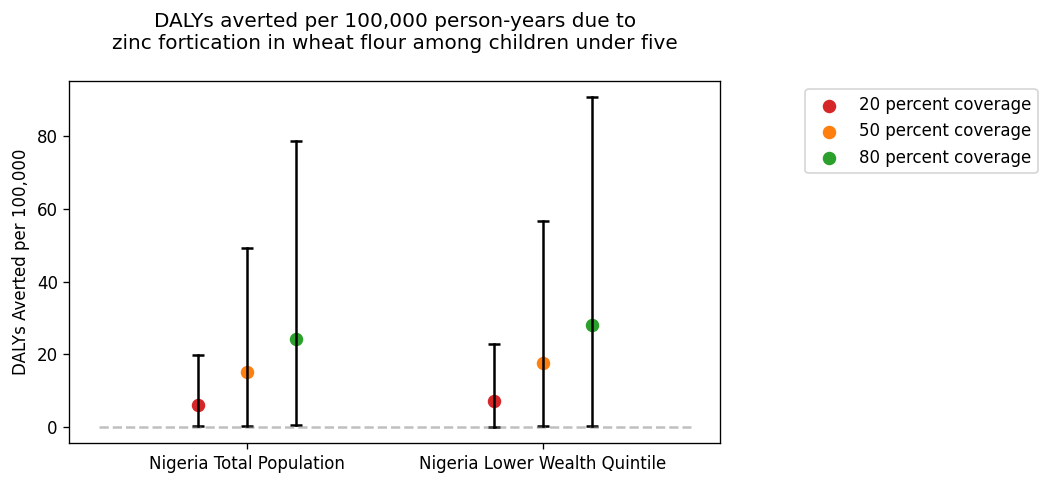

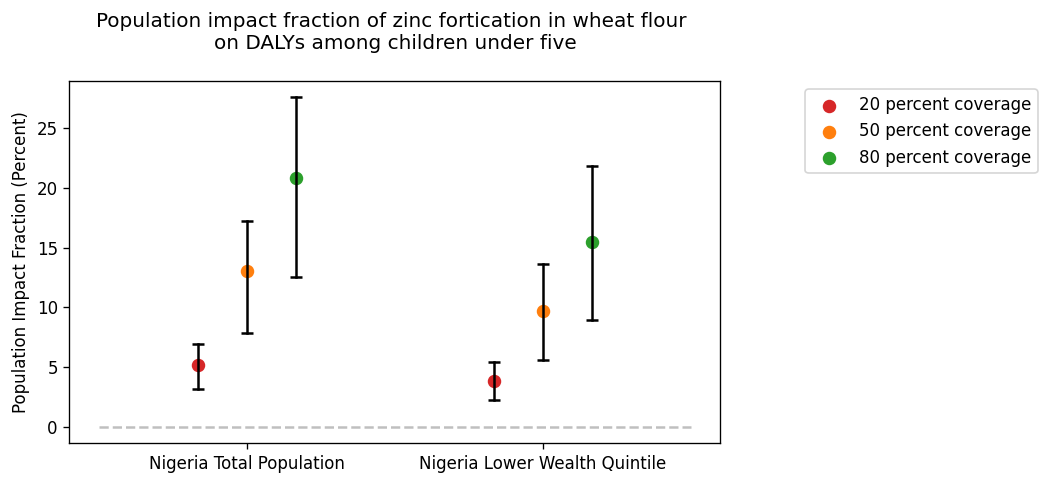

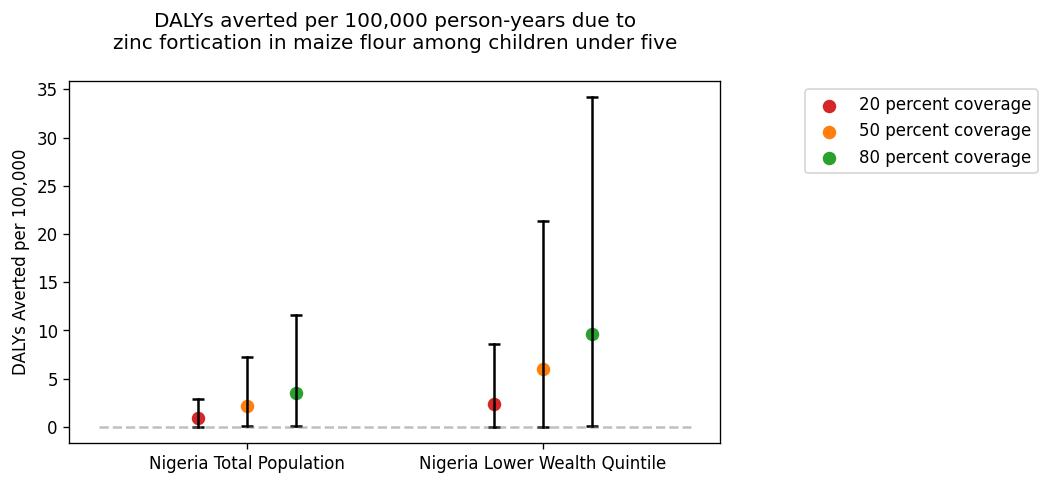

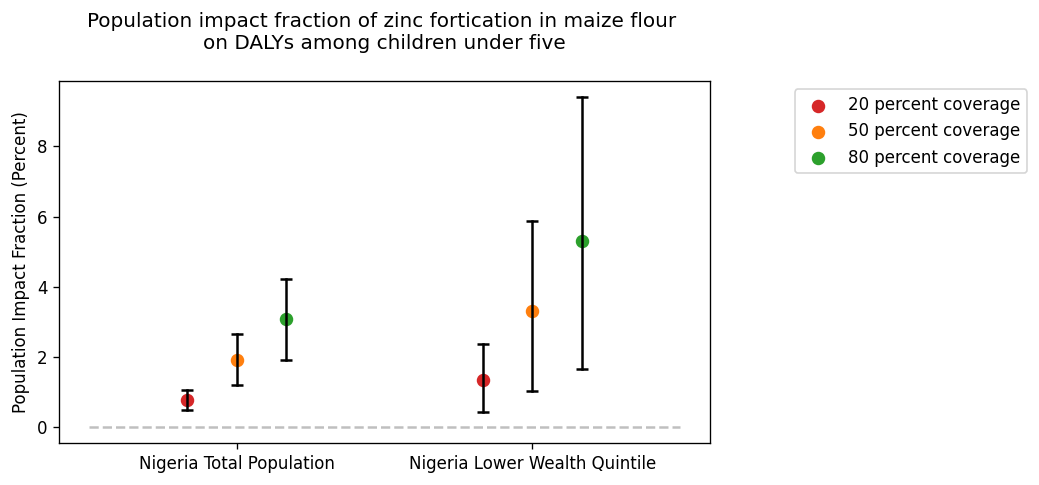

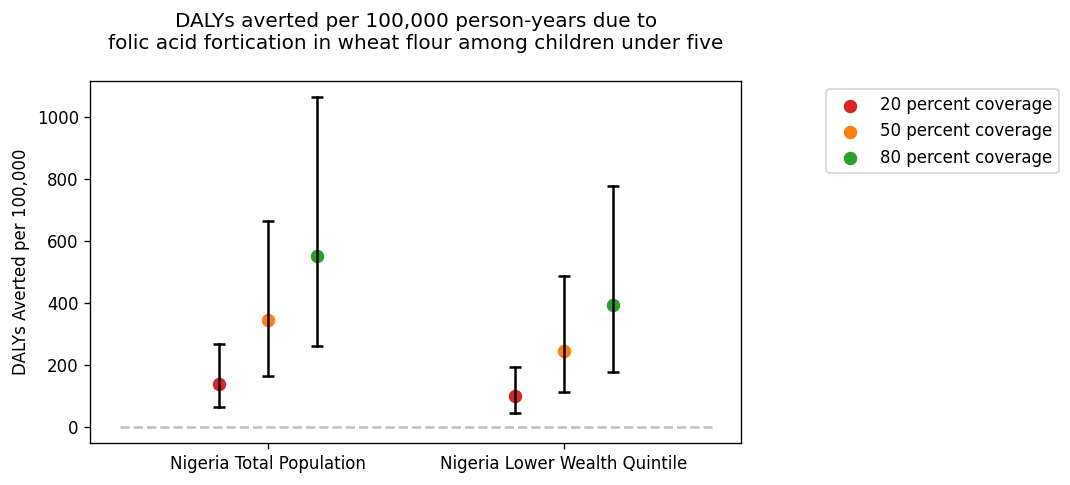

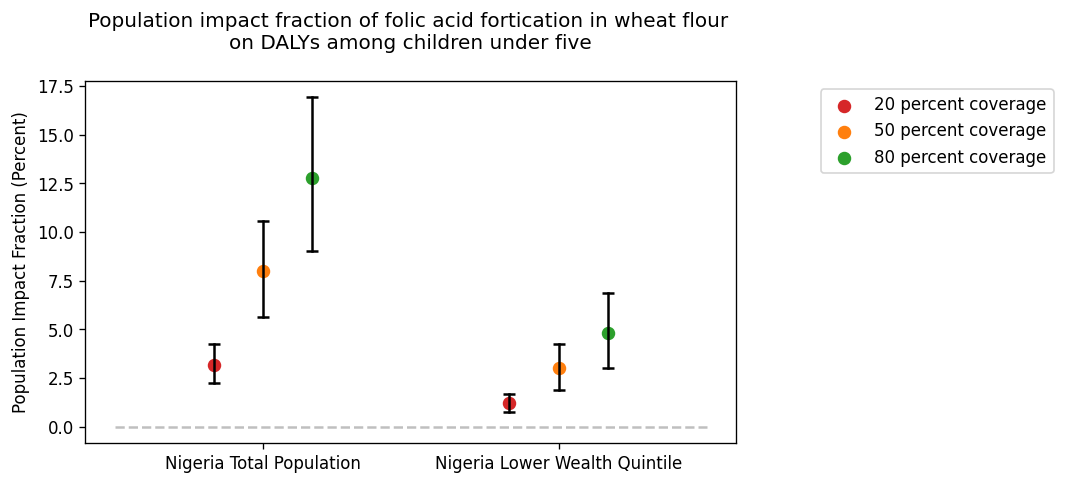

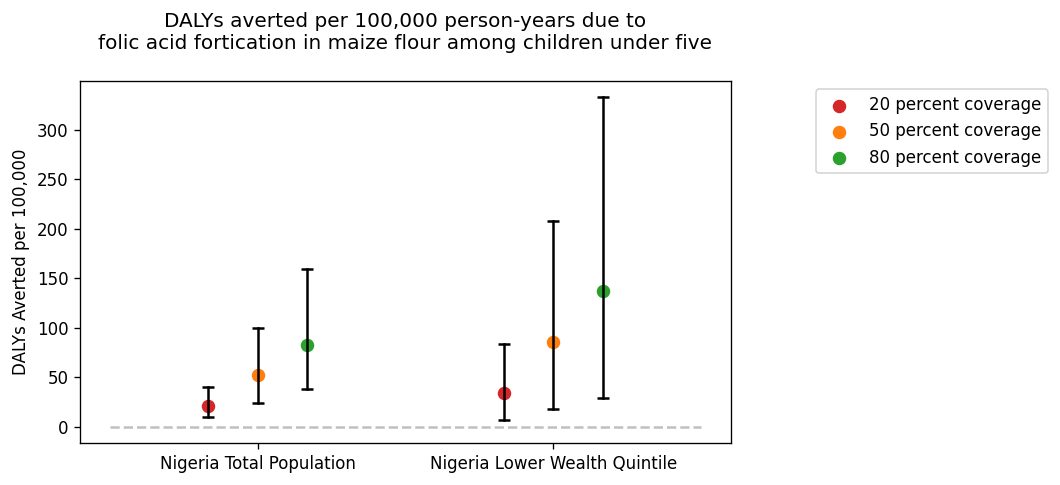

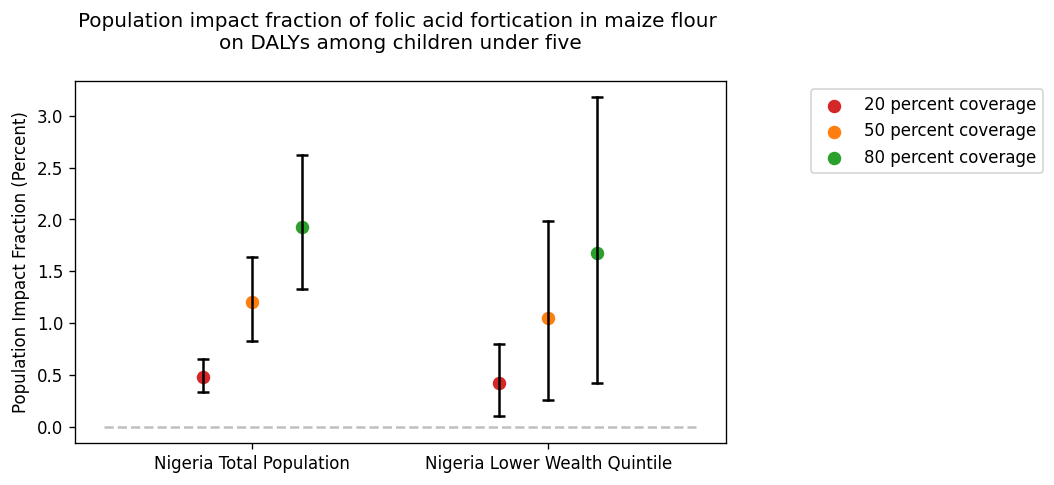

In [57]:
with PdfPages('results_plots/nigeria_lower_wealth_quintile_impact_by_nutrient_vehicle_pair.pdf') as pdf:
    for nutrient in ['vitamin a', 'zinc', 'folic acid']:
        if nutrient == 'vitamin a':
            vehicles = ['oil','wheat flour','maize flour']
        else:
            vehicles = ['wheat flour','maize flour']
        for vehicle in vehicles:
            make_ses_comparison_dot_plots((results
                                .sort_values(by='subgroup', ascending=False)
                                .loc[results.measure=='rates_averted']
                                .loc[results.vehicle==vehicle]
                                .loc[results.nutrient==nutrient]
                                .set_index([c for c in results.columns if 'draw' not in c])), 
                                nutrient, vehicle, 'rates', coverage_levels, '')
            pdf.savefig(bbox_inches='tight')
            make_ses_comparison_dot_plots((results
                                .sort_values(by='subgroup', ascending=False)
                                .loc[results.measure=='pif']
                                .loc[results.vehicle==vehicle]
                                .loc[results.nutrient==nutrient]
                                .set_index([c for c in results.columns if 'draw' not in c])), 
                                nutrient, vehicle, 'pifs', coverage_levels, '')
            pdf.savefig(bbox_inches='tight')

# Coverage

In [58]:
nat_cov = pd.read_pickle(vivarium_research_lsff_path + '/multiplication_models/results_raw/coverage_u5.pkl')
nat_cov = nat_cov.loc[nat_cov.location_id.isin(vitamin_a_results.reset_index().location_id.unique())]
nat_cov.head()

,coverage_level,location_id,year,nutrient,vehicle,mean,2.5%,97.5%,location_name,score,label
441,baseline,214,2021.0,vitamin a,oil,0.074508,0.057433,0.091706,Nigeria,4,***** Nigeria
442,baseline,214,2022.0,vitamin a,oil,0.074508,0.057433,0.091706,Nigeria,4,***** Nigeria
443,baseline,214,2023.0,vitamin a,oil,0.074508,0.057433,0.091706,Nigeria,4,***** Nigeria
444,baseline,214,2024.0,vitamin a,oil,0.074508,0.057433,0.091706,Nigeria,4,***** Nigeria
445,baseline,214,2025.0,vitamin a,oil,0.074508,0.057433,0.091706,Nigeria,4,***** Nigeria


In [59]:
folic_acid_baseline_coverage, folic_acid_counterfactual_coverage = get_baseline_and_counterfactual_coverage(coverage_data_dir,
                                             location_ids,
                                             nutrient,
                                             vehicles,
                                             years,
                                             coverage_levels, 'WRA')

Excluded location IDs [] due to missing data
Excluded location IDs [] due to missing data


In [60]:
vitamin_a_baseline_coverage['coverage_level'] = 'baseline'
vitamin_a_baseline_coverage['nutrient'] = 'vitamin a'
vitamin_a_counterfactual_coverage['nutrient'] = 'vitamin a'
zinc_baseline_coverage['coverage_level'] = 'baseline'
zinc_baseline_coverage['nutrient'] = 'zinc'
zinc_counterfactual_coverage['nutrient'] = 'zinc'
folic_acid_baseline_coverage['coverage_level'] = 'baseline'
folic_acid_baseline_coverage['nutrient'] = 'folic acid'
folic_acid_counterfactual_coverage['nutrient'] = 'folic acid'

max_cov_ses = pd.DataFrame()
for nutrient in ['vitamin a','zinc','folic acid']:
    if nutrient == 'vitamin a':
        vehicles = ['oil','wheat flour','maize flour']
    else:
        vehicles = ['wheat flour', 'maize flour']
    for vehicle in vehicles:
        print(f'calculating {nutrient}/{vehicle}')
        cov_a, cov_b = generate_logical_coverage_draws(coverage_data_dir, location_ids, nutrient, vehicle, 'U5')
        cov_b['coverage_level'] = 'maximum'
        cov_b['nutrient'] = nutrient
        cov_b['vehicle'] = vehicle
        max_cov_ses = pd.concat([max_cov_ses, cov_b])

ses_cov = pd.concat([vitamin_a_baseline_coverage,
                    vitamin_a_counterfactual_coverage,
                    zinc_baseline_coverage,
                    zinc_counterfactual_coverage,
                    folic_acid_baseline_coverage,
                    folic_acid_counterfactual_coverage,
                    max_cov_ses.reset_index()], ignore_index=True, sort=True)
l = get_ids('location')
ses_cov = ses_cov.merge(l.filter(['location_name','location_id']), on='location_id')
ses_cov['location_id'] = ses_cov['location_id'] + 0.5
ses_cov = ses_cov.set_index([c for c in ses_cov.columns if 'draw' not in c])
ses_cov = ses_cov.apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1).filter(['mean','2.5%','97.5%']).reset_index()
ses_cov.head()

calculating vitamin a/oil
Excluded location IDs [] due to missing data
calculating vitamin a/wheat flour
Excluded location IDs [] due to missing data
calculating vitamin a/maize flour
Excluded location IDs [] due to missing data
calculating zinc/wheat flour
Excluded location IDs [] due to missing data
calculating zinc/maize flour
Excluded location IDs [] due to missing data
calculating folic acid/wheat flour
Excluded location IDs [] due to missing data
calculating folic acid/maize flour
Excluded location IDs [] due to missing data


,coverage_level,location_id,nutrient,vehicle,year,location_name,mean,2.5%,97.5%
0,baseline,214.5,vitamin a,oil,2021.0,Nigeria,0.054369,0.016867,0.090144
1,baseline,214.5,vitamin a,oil,2022.0,Nigeria,0.054369,0.016867,0.090144
2,baseline,214.5,vitamin a,oil,2023.0,Nigeria,0.054369,0.016867,0.090144
3,baseline,214.5,vitamin a,oil,2024.0,Nigeria,0.054369,0.016867,0.090144
4,baseline,214.5,vitamin a,oil,2025.0,Nigeria,0.054369,0.016867,0.090144


In [61]:
cov_prepped = pd.concat([ses_cov, nat_cov], ignore_index=True, sort=True)#.drop(columns='score')
cov_prepped['label'] = cov_prepped.location_name + np.where(cov_prepped.location_id ==214,
                                                          ' Total Population', ' Lower Wealth Quintile')
cov_prepped.head()

,2.5%,97.5%,coverage_level,label,location_id,location_name,mean,nutrient,score,vehicle,year
0,0.016867,0.090144,baseline,Nigeria Lower Wealth Quintile,214.5,Nigeria,0.054369,vitamin a,NaN,oil,2021.0
1,0.016867,0.090144,baseline,Nigeria Lower Wealth Quintile,214.5,Nigeria,0.054369,vitamin a,NaN,oil,2022.0
2,0.016867,0.090144,baseline,Nigeria Lower Wealth Quintile,214.5,Nigeria,0.054369,vitamin a,NaN,oil,2023.0
3,0.016867,0.090144,baseline,Nigeria Lower Wealth Quintile,214.5,Nigeria,0.054369,vitamin a,NaN,oil,2024.0
4,0.016867,0.090144,baseline,Nigeria Lower Wealth Quintile,214.5,Nigeria,0.054369,vitamin a,NaN,oil,2025.0


In [62]:
cov_prepped.coverage_level.unique()

array(['baseline', 0.2, 0.5, 0.8, 'maximum'], dtype=object)

In [63]:
def make_coverage_bar_charts(data, location_ids, nutrient, vehicle):
    plt.figure(figsize=(10, 4), dpi=120)
    
    data = (data
            .loc[data.vehicle==vehicle]
            .loc[data.nutrient.isin(['na',nutrient])]
            .loc[data.location_id.isin(location_ids)]
            .loc[data.year.isin([np.nan,2025])]
            .sort_values(by=['location_id'], ascending=True))
    data['mean'] = data['mean'] * 100
    data['2.5%'] = data['2.5%'] * 100
    data['97.5%'] = data['97.5%'] * 100
    base = data.loc[data.coverage_level=='baseline']
    alt_20 = data.loc[data.coverage_level==0.2]
    alt_50 = data.loc[data.coverage_level==0.5]
    alt_80 = data.loc[data.coverage_level==0.8]
    barWidth = 0.20
    a = np.arange(len(base))
    b = [x + barWidth for x in a]
    c = [x + barWidth for x in b]
    d = [x + barWidth for x in c]
    plt.bar(a, base['mean'], width=barWidth, yerr = [base['mean'] - base['2.5%'],base['97.5%'] - base['mean']], 
            label='Baseline Coverage')
    plt.bar(b, alt_20['mean'], width=barWidth, yerr = [alt_20['mean'] - alt_20['2.5%'],alt_20['97.5%'] - alt_20['mean']], 
            color='tab:red', label='20% Coverage')
    plt.bar(c, alt_50['mean'], width=barWidth, yerr = [alt_50['mean'] - alt_50['2.5%'],alt_50['97.5%'] - alt_50['mean']], 
            color='tab:orange', label='50% Coverage')
    plt.bar(d, alt_80['mean'], width=barWidth, yerr = [alt_80['mean'] - alt_80['2.5%'],alt_80['97.5%'] - alt_80['mean']], 
            color='tab:green', label='80% Coverage')

    df = data.loc[data.coverage_level=='maximum']
    for i in list(range(0,len(df.location_id.unique()))):
        if i == 0:
            plt.hlines(df.loc[df.location_id==df.location_id.unique()[i]]['mean'], -0.1 + i, 0.7 + i, 
                   linestyle='dashed', color='black', label='Eating industrially produced vehicle')
        else: 
            plt.hlines(df.loc[df.location_id==df.location_id.unique()[i]]['mean'], -0.1 + i, 0.7 + i, 
                   linestyle='dashed', color='black')
        plt.fill_between([-0.1 + i, 0.7 + i], [df.loc[df.location_id==df.location_id.unique()[i]]['2.5%'].values[0]] * 2,
                        [df.loc[df.location_id==df.location_id.unique()[i]]['97.5%'].values[0]] * 2,
                        alpha=0.2, color='black')
    
    plt.legend(bbox_to_anchor=[1.45,1])
    plt.title(f'{nutrient.capitalize()} in {vehicle} fortification coverage')
    plt.ylabel('Percent of population')
    plt.xticks([r + barWidth * 1.5 for r in range(len(df))], base['label'].values)

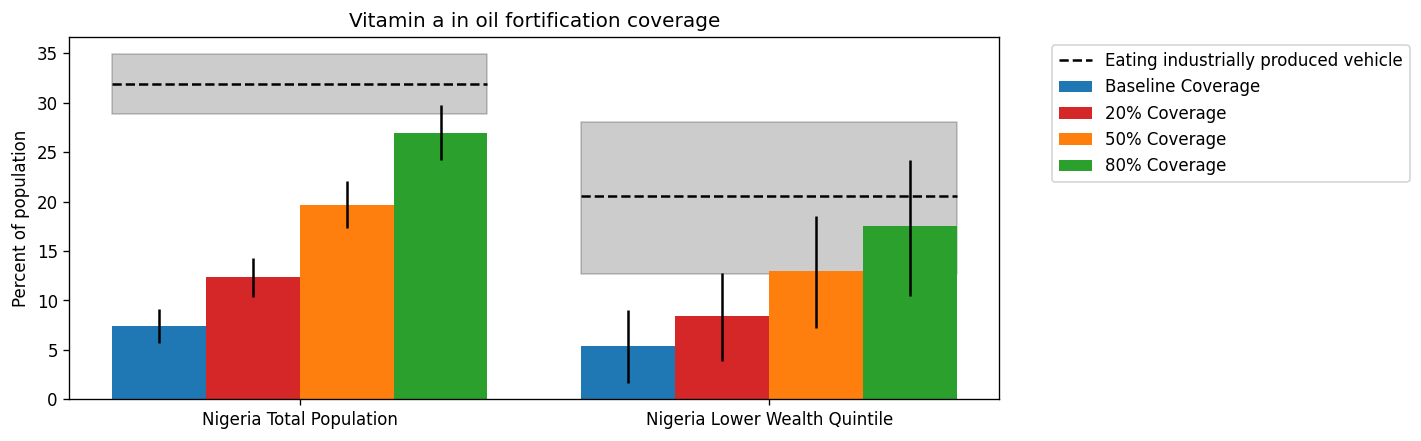

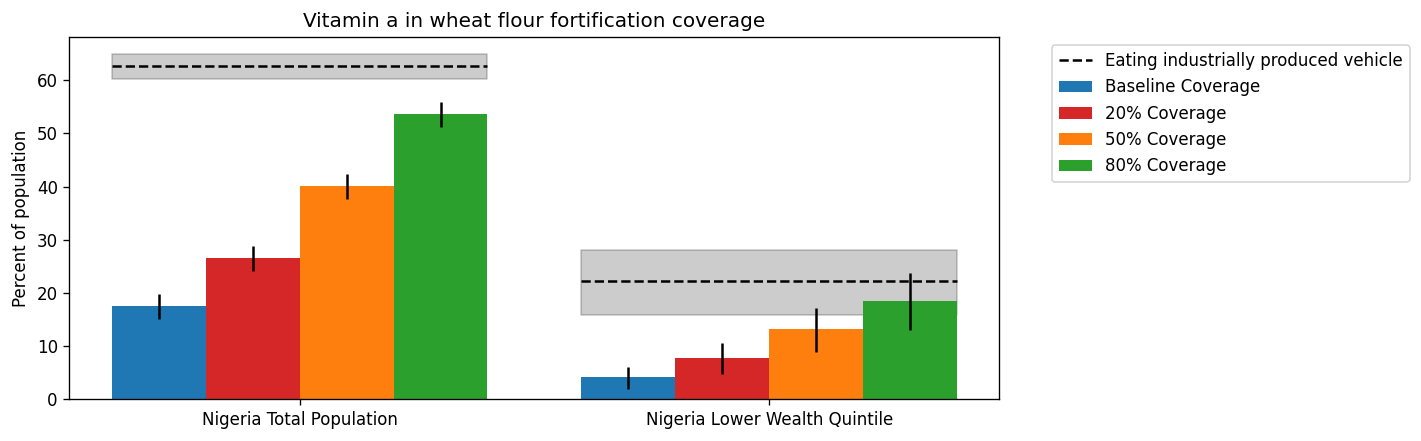

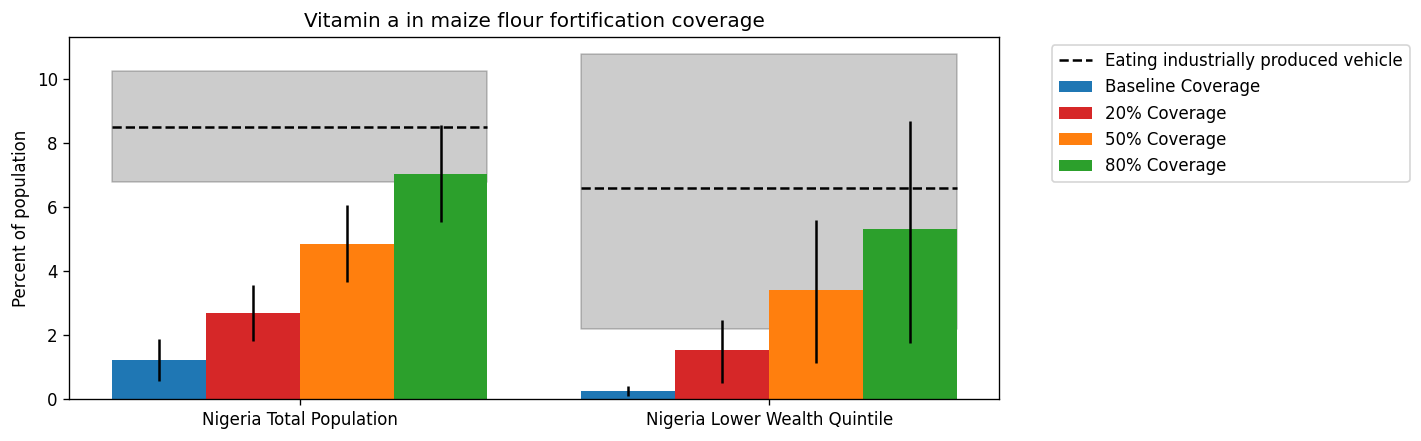

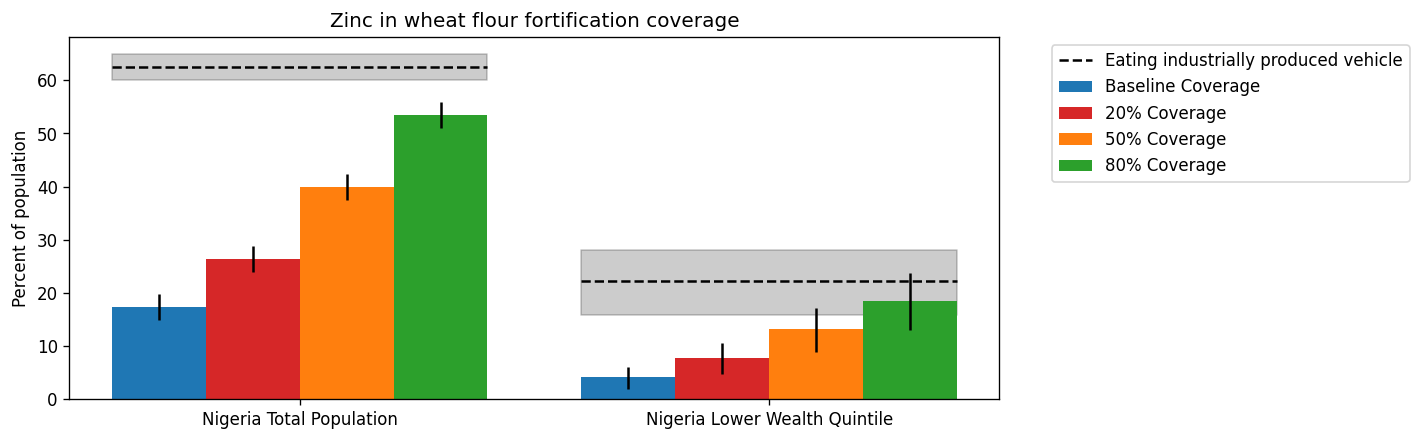

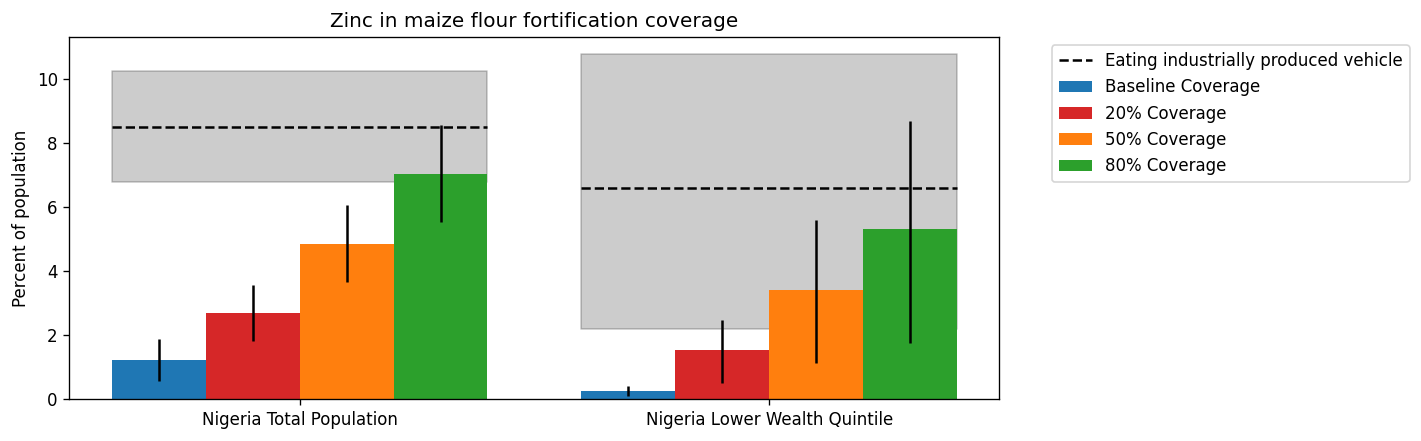

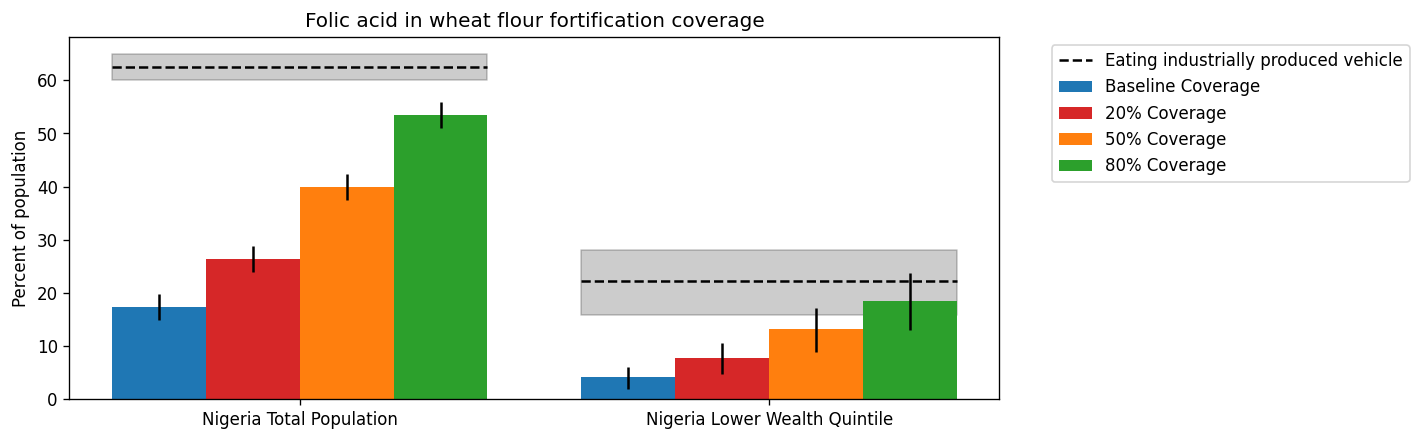

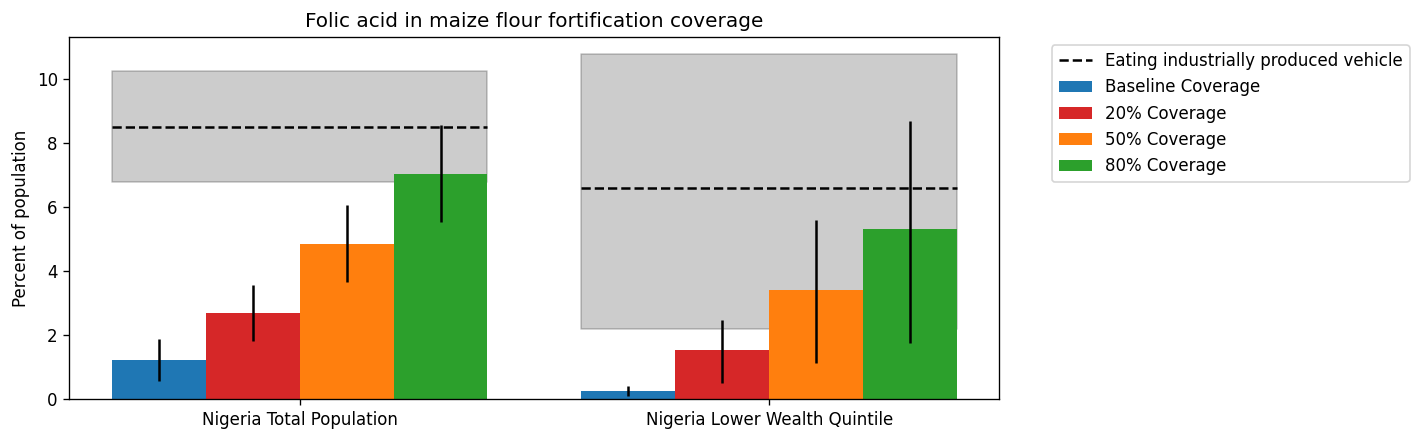

In [64]:
with PdfPages('results_plots/nigeria_lower_wealth_quintile_coverage_by_nutrient_vehicle_pair.pdf') as pdf:
    for nutrient in ['vitamin a','zinc','folic acid']:
        if nutrient == 'vitamin a':
            vehicles = ['oil','wheat flour','maize flour']
        else:
            vehicles = ['wheat flour', 'maize flour']
        for vehicle in vehicles:
            make_coverage_bar_charts(cov_prepped, [214,214.5], nutrient, vehicle)
            pdf.savefig(bbox_inches='tight')

# Excel file

In [65]:
impact = (results
          .loc[results.year==2025]
          .loc[results.measure.isin(['pif','rates_averted'])]
          .set_index([c for c in results.columns if 'draw' not in c])
          .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
          .rename(columns={'mean':'mean_val','2.5%':'lower','97.5%':'upper'})
          .filter(['mean_val','lower','upper'])
          .reset_index()
          .replace('vitamin a','vitamin A')
          .drop(columns='index'))
l = get_ids('location')
impact = impact.merge(l.filter(['location_name','location_id']), on='location_id')
for col in ['mean_val','lower','upper']:
    impact[f'{col}'] = np.where(impact.measure.isin(['pif','deficiency_exposure']),
                                           impact[f'{col}'].map('{:.1f}'.format),
                                           impact[f'{col}'].map('{:,.0f}'.format))
impact['value'] = (impact['mean_val'].astype(str)
                    +'\r\n('
                    +impact['lower'].astype(str)
                    +', '
                    +impact['upper'].astype(str)
                    +')')
impact['col_name'] = (impact.nutrient.str.capitalize()
                      + ' in '
                      + impact.vehicle
                      + np.where(impact.measure == 'pif', ' PIF (percent): ',
                                np.where(impact.measure == 'rates_averted', ' DALYs averted per 100,000 person-years: ', 'ERROR'))
                      + (impact.coverage_level * 100).astype(str)
                       + '% scale-up')
impact['location_name'] = impact['location_name'] + ' ' + impact['subgroup']
impact = impact[['col_name','location_name','value']]
impact = impact.pivot_table(index='location_name',
                                     columns='col_name', 
                                     values='value',
                                     aggfunc=lambda x: ' '.join(x))   
impact = impact.replace(np.nan, 'Not modeled')
impact

col_name,"Folic acid in maize flour DALYs averted per 100,000 person-years: 20.0% scale-up","Folic acid in maize flour DALYs averted per 100,000 person-years: 50.0% scale-up","Folic acid in maize flour DALYs averted per 100,000 person-years: 80.0% scale-up",Folic acid in maize flour PIF (percent): 20.0% scale-up,Folic acid in maize flour PIF (percent): 50.0% scale-up,Folic acid in maize flour PIF (percent): 80.0% scale-up,"Folic acid in wheat flour DALYs averted per 100,000 person-years: 20.0% scale-up","Folic acid in wheat flour DALYs averted per 100,000 person-years: 50.0% scale-up","Folic acid in wheat flour DALYs averted per 100,000 person-years: 80.0% scale-up",Folic acid in wheat flour PIF (percent): 20.0% scale-up,...,"Zinc in maize flour DALYs averted per 100,000 person-years: 80.0% scale-up",Zinc in maize flour PIF (percent): 20.0% scale-up,Zinc in maize flour PIF (percent): 50.0% scale-up,Zinc in maize flour PIF (percent): 80.0% scale-up,"Zinc in wheat flour DALYs averted per 100,000 person-years: 20.0% scale-up","Zinc in wheat flour DALYs averted per 100,000 person-years: 50.0% scale-up","Zinc in wheat flour DALYs averted per 100,000 person-years: 80.0% scale-up",Zinc in wheat flour PIF (percent): 20.0% scale-up,Zinc in wheat flour PIF (percent): 50.0% scale-up,Zinc in wheat flour PIF (percent): 80.0% scale-up
location_name,,,,,,,,,,,,,,,,,,,,,
Nigeria Lower Wealth Quintile,"34\r\n(7, 83)","86\r\n(18, 208)","137\r\n(30, 333)","0.4\r\n(0.1, 0.8)","1.1\r\n(0.3, 2.0)","1.7\r\n(0.4, 3.2)","98\r\n(44, 194)","246\r\n(111, 485)","394\r\n(178, 777)","1.2\r\n(0.8, 1.7)",...,"10\r\n(0, 34)","1.3\r\n(0.4, 2.3)","3.3\r\n(1.0, 5.9)","5.3\r\n(1.7, 9.4)","7\r\n(0, 23)","18\r\n(0, 57)","28\r\n(0, 91)","3.9\r\n(2.2, 5.5)","9.7\r\n(5.6, 13.6)","15.5\r\n(9.0, 21.8)"
Nigeria Total Population,"21\r\n(10, 40)","52\r\n(24, 99)","83\r\n(38, 159)","0.5\r\n(0.3, 0.7)","1.2\r\n(0.8, 1.6)","1.9\r\n(1.3, 2.6)","137\r\n(65, 265)","343\r\n(163, 664)","549\r\n(261, 1,062)","3.2\r\n(2.3, 4.2)",...,"4\r\n(0, 12)","0.8\r\n(0.5, 1.1)","1.9\r\n(1.2, 2.6)","3.1\r\n(1.9, 4.2)","6\r\n(0, 20)","15\r\n(0, 49)","24\r\n(0, 79)","5.2\r\n(3.1, 6.9)","13.0\r\n(7.9, 17.2)","20.9\r\n(12.6, 27.6)"


In [66]:
coverage = cov_prepped
coverage = coverage.loc[coverage.year==2025].loc[coverage.nutrient!='iron']
coverage['subgroup'] = np.where(coverage.location_id==214, 'Total Population', 'Lower Wealth Quintile')
coverage['location_name'] = coverage['location_name'] + ' ' + coverage['subgroup']


coverage['value'] = ((coverage['mean'] * 100).round(1).astype(str)
                        +'\r\n('
                        +(coverage['2.5%'] * 100).round(1).astype(str)
                        +', '
                        +(coverage['97.5%'] * 100).round(1).astype(str)
                        +')')

coverage['parameter_description'] = np.where(coverage.coverage_level == 'baseline', 'Percent of population eating ' + coverage.nutrient + ' fortified ' + coverage.vehicle +' at baseline',
                                            np.where(coverage.coverage_level == 'maximum', f'Percent of population eating fortifiable ' + coverage.vehicle, 
                                            'Percent of population eating ' + coverage.nutrient + ' fortified ' + coverage.vehicle + ': ' + (coverage.coverage_level * 100).astype(str) + '0% scale-up'))

coverage['parameter_description'] = coverage['parameter_description'].str.replace('.00%','%')
coverage = coverage[['location_name','value','parameter_description']]
coverage = coverage.pivot_table(index='location_name',
                                     columns='parameter_description', 
                                     values='value',
                                     aggfunc=lambda x: ' '.join(x))   
coverage = coverage.replace(np.nan, 'Not modeled')

coverage

parameter_description,Percent of population eating folic acid fortified maize flour at baseline,Percent of population eating folic acid fortified maize flour: 20% scale-up,Percent of population eating folic acid fortified maize flour: 50% scale-up,Percent of population eating folic acid fortified maize flour: 80% scale-up,Percent of population eating folic acid fortified wheat flour at baseline,Percent of population eating folic acid fortified wheat flour: 20% scale-up,Percent of population eating folic acid fortified wheat flour: 50% scale-up,Percent of population eating folic acid fortified wheat flour: 80% scale-up,Percent of population eating vitamin a fortified maize flour at baseline,Percent of population eating vitamin a fortified maize flour: 20% scale-up,...,Percent of population eating vitamin a fortified wheat flour: 50% scale-up,Percent of population eating vitamin a fortified wheat flour: 80% scale-up,Percent of population eating zinc fortified maize flour at baseline,Percent of population eating zinc fortified maize flour: 20% scale-up,Percent of population eating zinc fortified maize flour: 50% scale-up,Percent of population eating zinc fortified maize flour: 80% scale-up,Percent of population eating zinc fortified wheat flour at baseline,Percent of population eating zinc fortified wheat flour: 20% scale-up,Percent of population eating zinc fortified wheat flour: 50% scale-up,Percent of population eating zinc fortified wheat flour: 80% scale-up
location_name,,,,,,,,,,,,,,,,,,,,,
Nigeria Lower Wealth Quintile,"0.3\r\n(0.1, 0.4)","1.5\r\n(0.5, 2.5)","3.4\r\n(1.1, 5.6)","5.3\r\n(1.8, 8.7)","4.1\r\n(1.9, 6.1)","7.7\r\n(4.7, 10.5)","13.2\r\n(8.9, 17.1)","18.6\r\n(13.1, 23.7)","0.3\r\n(0.1, 0.4)","1.5\r\n(0.5, 2.5)",...,"13.2\r\n(8.9, 17.1)","18.6\r\n(13.1, 23.7)","0.3\r\n(0.1, 0.4)","1.5\r\n(0.5, 2.5)","3.4\r\n(1.1, 5.6)","5.3\r\n(1.8, 8.7)","4.1\r\n(1.9, 6.1)","7.7\r\n(4.7, 10.5)","13.2\r\n(8.9, 17.1)","18.6\r\n(13.1, 23.7)"
Nigeria Total Population,"1.2\r\n(0.6, 1.9)","2.7\r\n(1.8, 3.6)","4.9\r\n(3.7, 6.1)","7.0\r\n(5.5, 8.6)","17.4\r\n(14.9, 19.8)","26.4\r\n(23.9, 28.8)","39.9\r\n(37.5, 42.4)","53.5\r\n(51.0, 55.9)","1.2\r\n(0.6, 1.9)","2.7\r\n(1.8, 3.6)",...,"40.0\r\n(37.7, 42.3)","53.6\r\n(51.2, 55.9)","1.2\r\n(0.6, 1.9)","2.7\r\n(1.8, 3.6)","4.9\r\n(3.7, 6.1)","7.0\r\n(5.5, 8.6)","17.4\r\n(14.9, 19.8)","26.4\r\n(23.9, 28.8)","39.9\r\n(37.5, 42.4)","53.5\r\n(51.0, 55.9)"


In [67]:
low_ses_table = pd.concat([coverage.T, impact.T])
low_ses_table.to_csv('results_plots/nigeria_lower_wealth_quintile_no_iron.csv')
low_ses_table

location_name,Nigeria Lower Wealth Quintile,Nigeria Total Population
Percent of population eating folic acid fortified maize flour at baseline,"0.3\r\n(0.1, 0.4)","1.2\r\n(0.6, 1.9)"
Percent of population eating folic acid fortified maize flour: 20% scale-up,"1.5\r\n(0.5, 2.5)","2.7\r\n(1.8, 3.6)"
Percent of population eating folic acid fortified maize flour: 50% scale-up,"3.4\r\n(1.1, 5.6)","4.9\r\n(3.7, 6.1)"
Percent of population eating folic acid fortified maize flour: 80% scale-up,"5.3\r\n(1.8, 8.7)","7.0\r\n(5.5, 8.6)"
Percent of population eating folic acid fortified wheat flour at baseline,"4.1\r\n(1.9, 6.1)","17.4\r\n(14.9, 19.8)"
...,...,...
"Zinc in wheat flour DALYs averted per 100,000 person-years: 50.0% scale-up","18\r\n(0, 57)","15\r\n(0, 49)"
"Zinc in wheat flour DALYs averted per 100,000 person-years: 80.0% scale-up","28\r\n(0, 91)","24\r\n(0, 79)"
Zinc in wheat flour PIF (percent): 20.0% scale-up,"3.9\r\n(2.2, 5.5)","5.2\r\n(3.1, 6.9)"
Zinc in wheat flour PIF (percent): 50.0% scale-up,"9.7\r\n(5.6, 13.6)","13.0\r\n(7.9, 17.2)"
